# Unsupervised Clustering of Scientific Abstracts from Cornell's ARXIV database


# TOC:
## 0. Loading large data and Computing Parallelly on PC with Dask
## 1. Data-cleaning and feature engineering
## 2. Spacy Tokenizer, Stopwords, Punctuations
## 3. Vectorization and dimensionality reduction
## 4. K-means
## 5. t-SNE vs umap 
## 6. K-means
## 7. Interactive mapping

# 0. Loading large data and Computing Parallelly on PC with Dask

In [1]:
import logging
logger = logging.getLogger("spacy")
logger.setLevel(logging.ERROR)

import dask.bag as db
import json
import pandas as pd

docs = db.read_text('../input/arxiv/arxiv-metadata-oai-snapshot.json').map(json.loads)

## Total number of documents: 


In [2]:
docs.count().compute()

2182279

## Looking at individual documents:


In [40]:
docs.take(5)

({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

## get a subset 


In [4]:


get_latest_version = lambda x: x['versions'][-1]['created']


# get a subset 
trim = lambda x: {'id': x['id'],
                  'authors': x['authors'],
                  'title': x['title'],
                  'doi': x['doi'],
                  'category':x['categories'].split(' '),
                  'abstract':x['abstract'],}


# filter by time
columns = ['id','category','abstract']
docs_df = (docs.filter(lambda x: int(get_latest_version(x).split(' ')[3]) > 2018)
           .map(trim).
           compute())

docs_df = pd.DataFrame(docs_df)

In [5]:
docs_df.to_csv("trimmed_arxiv_docs.csv", index=False)

In [41]:
docs_df.tail()

id                                            authors  \
747203  quant-ph/0612050                             Igor Devetak, Jon Yard   
747204  quant-ph/0701163                                       Daegene Song   
747205  quant-ph/0702160  Andrew M. Childs, Richard Cleve, Stephen P. Jo...   
747206  quant-ph/9606017                                        Arthur Jabs   
747207  quant-ph/9806088           J. Eisert, M. Wilkens, and M. Lewenstein   

                                                    title  \
747203  The exact cost of redistributing multipartite ...   
747204              Thermodynamics of Quantum Measurement   
747205    Discrete-query quantum algorithm for NAND trees   
747206              Quantum Mechanics in Terms of Realism   
747207               Quantum Games and Quantum Strategies   

                                   doi    category  \
747203  10.1103/PhysRevLett.100.230501  [quant-ph]   
747204                            None  [quant-ph]   
747205       10.4086/toc.2009.v005a005  [quant-ph]   
747206                            None  [quant-ph]   
747207     10.1103/PhysRevLett.83.3077  [quant-ph]   

                                                 abstract  
747203    How correlated are two quantum systems from ...  
747204    Von Neumann's quantum measurement protocol i...  
747205    Recently, Farhi, Goldstone, and Gutmann gave...  
747206    .We expound an alternative to the Copenhagen...  
747207    We investigate the quantization of non-zero ...

# 1.Data-cleaning and feature engineering

In [7]:
df = pd.read_csv("./trimmed_arxiv_docs.csv")

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747208 entries, 0 to 747207
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        747208 non-null  object
 1   authors   747208 non-null  object
 2   title     747208 non-null  object
 3   doi       265981 non-null  object
 4   category  747208 non-null  object
 5   abstract  747208 non-null  object
dtypes: object(6)
memory usage: 34.2+ MB


# word counts of each abstract


In [10]:
df['abstract_word_count'] = docs_df['abstract'].apply(lambda x: len(x.strip().split())) 

In [11]:
df['abstract'].describe(include='all')

count                                   747208
unique                                  747067
top         Full abstract in the manuscript.\n
freq                                         3
Name: abstract, dtype: object

## remove duplicated abstracts


In [12]:
df.drop_duplicates(['abstract',], inplace=True)
df['abstract'].describe(include='all')

count                                                747067
unique                                               747067
top         Compact multi-channel radiation detectors re...
freq                                                      1
Name: abstract, dtype: object

# 2. Spacy Tokenizer, Stopwords, Punctuations

## look at 10000 rows

In [13]:
df = df.sample(10000, random_state=42)

# tqdm is a library used for creating Progress Bars, and en_core_sci_lg is for scientific text 

In [14]:
from tqdm import tqdm
from IPython.utils import io
with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz

# spaCy is an open-source software library for advanced natural language processing

In [15]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS  
import en_core_sci_lg   

# Define a Parser Function


In [16]:
parser = en_core_sci_lg.load()
parser.max_length = 7000000 #Limit the size of the parser

def spacy_tokenizer(sentence):
    ''' Function to preprocess text of scientific papers 
        (e.g Removing Stopword and puntuations)'''
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ] # transform to lowercase and then split the scentence
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ] #remove stopsword an punctuation
    mytokens = " ".join([i for i in mytokens]) 
    return mytokens

# list of punctuation to remove 

In [17]:
import string

punctuations = string.punctuation 
stopwords = list(STOP_WORDS)
stopwords[:10]

['show',
 'three',
 'she',
 'nothing',
 'off',
 'towards',
 'upon',
 'few',
 'last',
 'down']

# 

In [18]:
tqdm.pandas()
df["processed_text"] = df["abstract"].progress_apply(spacy_tokenizer)

100%|██████████| 10000/10000 [08:47<00:00, 18.97it/s]


# 3. Vectorization and dimensionality reduction 

In [19]:
# Import vectorizer and define vec function
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [20]:
#vectorize each processed abstract
text = df['processed_text'].values
X = vectorize(text, 2 ** 12) #arbitrary max feature -_> Hyperpara. for optimisation (?)
X.shape

(10000, 4096)

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42) #Keep 95% of the variance
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(10000, 2801)

# 4. Kmeans for Clustering

In [22]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist
from sklearn import metrics

In [ ]:
# find optimal k value
r_seed = 14
cluster_errors = []

for i in range(10, 30):#50):
    n_clusters = i
    pipe_pca_kmean = Pipeline([("cluster", KMeans(n_clusters=n_clusters, random_state=r_seed, verbose=0))])#, n_jobs=1))])

    pipe_pca_kmean.fit(X_reduced)
    pipe_pca_kmean.predict(X_reduced)
    cluster_errors.append(pipe_pca_kmean.named_steps["cluster"].inertia_) 

In [ ]:
plt.clf()
plt.plot(cluster_errors, "o-")
plt.xlabel("k_clusters")
plt.ylabel("sum sq distances from mean")
plt.show()

# Choose k from elbow plot

In [25]:
k = 20 
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['kmean_clusters'] = y_pred

# 5. t-SNE vs umap

In [26]:
!pip install umap-learn

In [27]:
from umap import UMAP

In [28]:
# UMAP Definition:
umap_embeddings = UMAP(n_neighbors=100, min_dist=0.3, n_components=2)

In [29]:
X_umap = umap_embeddings.fit_transform(X_reduced)

In [30]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.047s...
[t-SNE] Computed neighbors for 10000 samples in 9.701s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.315505
[t-SNE] KL divergence after 50 iterations with early exaggeration: 83.335022
[t-SNE] KL divergence after 1000 iterations: 2.577638


## UMAP: Uniform Manifold Approximation and Projection 

* t-SNE and UMAP are both for data visualization. They are not meant to tell you about clustering or variation as much as methods like PCA do. 
* t-SNE and UMAP have the same principle and workflow: create a high dimensional graph, then reconstruct it in a lower dimensional space while retaining the structure.
### * t-SNE moves the high dimensional graph to a lower dimensional space points by points. UMAP compresses that graph.
* Key parameters for t-SNE and UMAP are the perplexity and number of neighbors, respectively. 
* UMAP is more time-saving due to the clever solution in creating a rough estimation of the high dimensional graph instead of measuring every point.
* UMAP gives a better balance between local versus global structure, thus overall gives a more accurate presentation of the global structure. This will come in handy in trajectory analysis. 

https://blog.bioturing.com/2022/01/14/umap-vs-t-sne-single-cell-rna-seq-data-visualization/#:~:text=t-SNE%20and%20UMAP%20have,UMAP%20compresses%20that%20graph.

# Before K-means: t-SNE vs Umap

<AxesSubplot:>

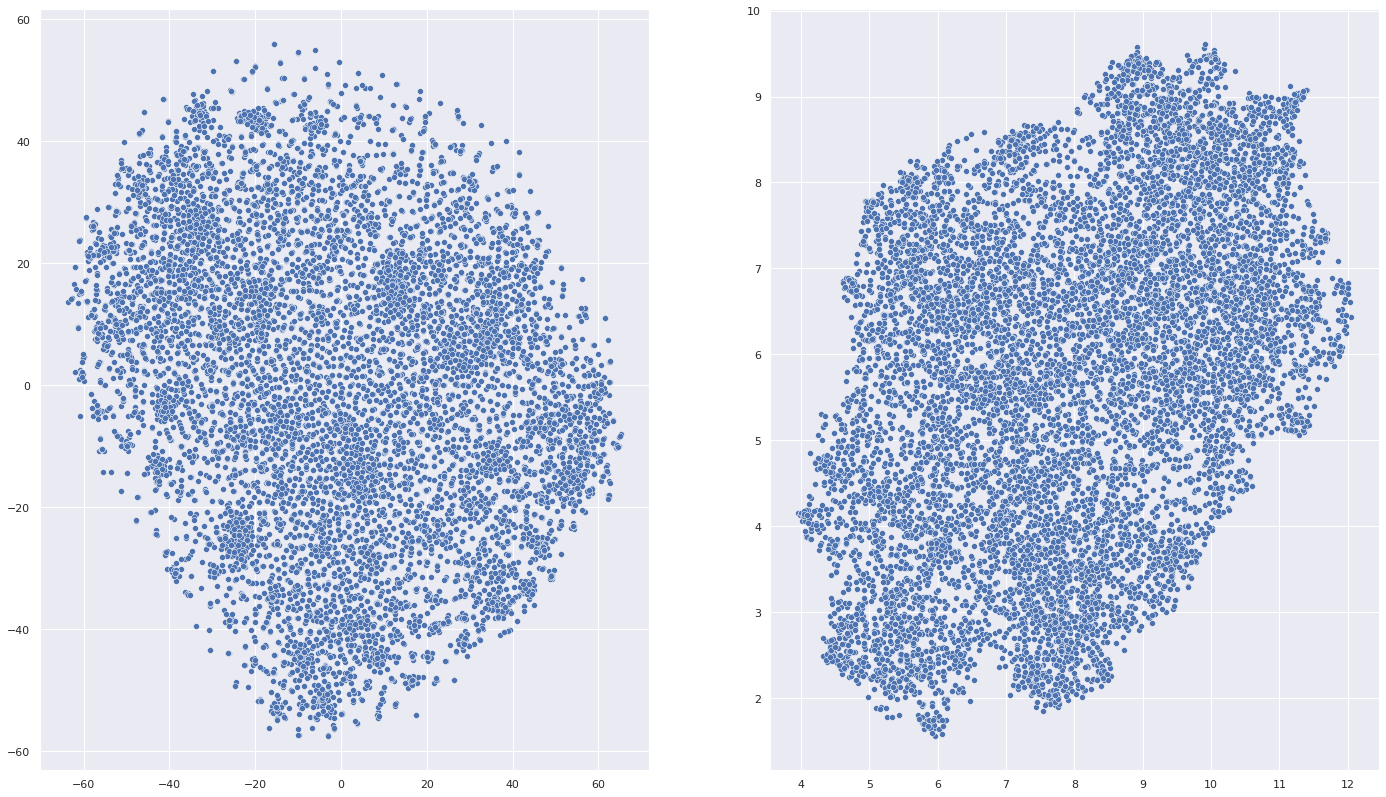

In [59]:
import seaborn as sns
fig,ax=plt.subplots(1,2,figsize=(24,14))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], ax=ax[0])
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], ax=ax[1])

# 6. Kmeans: t-SNE vs Umap 

<AxesSubplot:>

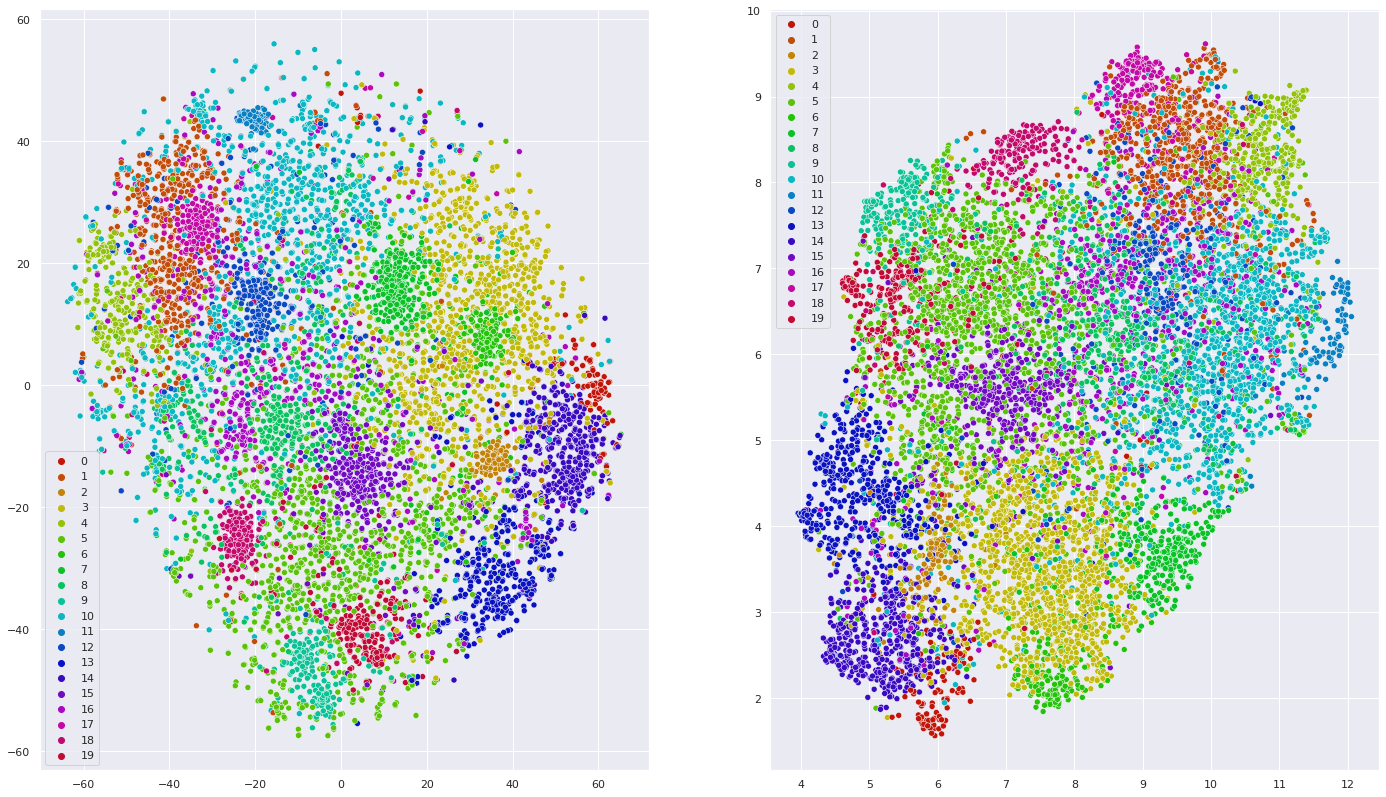

In [65]:
%matplotlib inline
fig,ax=plt.subplots(1,2,figsize=(24,14))

sns.set(rc={'figure.figsize':(15,15)})
palette = sns.hls_palette(20, l=.4, s=.9)
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y_pred, legend='full', ax=ax[0], palette=palette)

sns.set(rc={'figure.figsize':(15,15)})
palette = sns.hls_palette(20, l=.4, s=.9)
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=y_pred, legend='full', ax=ax[1], palette=palette)



# 7. Interactive mapping: t-SNE vs UMap

In [69]:
import plotly.express as px


fig = px.scatter(df, x=X_embedded[:,0], y=X_embedded[:,1], color=y_pred.astype(str),
                 hover_data=['id', 'authors', 'title',],
                 height= 1000, width=1000,
                title = "t-SNE with Kmeans (interactive)")
fig.show()


## For example, Color 14 for Astrophysics, Color 7 for Quantum

In [70]:
fig = px.scatter(df, x=X_umap[:,0], y=X_umap[:,1], color=y_pred.astype(str),
                 hover_data=['id', 'authors', 'title',],
                 height= 1000, width=1000,
                title = "Umap with Kmeans (interactive)")
fig.show()